In [1]:
import numpy as np
import pandas as pd
import cv2 as cv
import helper as hp
import scipy.io as sio
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from scipy.stats import spearmanr
plt.style.use('ggplot')

### Loading mat file 

In [2]:
data = sio.loadmat('/home/shikhar/Datasets/hw5/hw5.mat')
blur_orgs = data['blur_orgs'][0]
blur_dmos = data['blur_dmos'][0]

refnames_blur_temp = data['refnames_blur'][0]
refnames_blur = []
for refname in refnames_blur_temp:
    refnames_blur.append(refname[0])
    
print(len(blur_orgs), len(blur_dmos), len(refnames_blur))

174 174 174


### Loading Blur images

Total blur images: 145


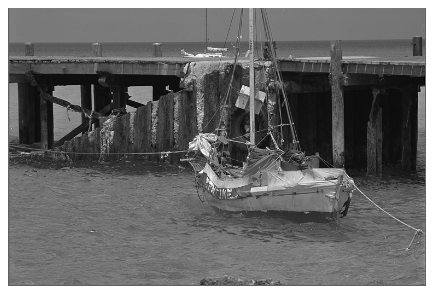

In [4]:
N_IMG = 174
blur_imgs = []

for i in range(1, N_IMG+1):
    filename = '/home/shikhar/Datasets/hw5/gblur/img' + str(i) + '.bmp'
    img = np.float32(cv.imread(filename, 0))
    blur_imgs.append(img)

N_BIMG = np.sum(blur_orgs == 0)
print('Total blur images:', N_BIMG)
hp.show(blur_imgs[173])

### Loading reference images 

Total reference images: 29


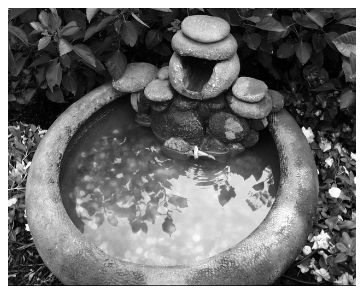

In [5]:
ref_names = list(set(refnames_blur)) # List of unique names of reference images
N_REFS = len(ref_names)
name_to_ind = dict()                 # Maps name to index
ref_imgs = []

index = 0
for refname in ref_names:
    filename = '/home/shikhar/Datasets/hw5/refimgs/' + refname
    img = np.float32(cv.imread(filename, 0))
    ref_imgs.append(img)
    name_to_ind[refname] = index
    index += 1

print('Total reference images:', len(ref_imgs))
hp.show(ref_imgs[name_to_ind['coinsinfountain.bmp']])

## Defining Metrics

In [6]:
# -----------------------------------Mean Square Error--------------------------------------
def metric1(X, Y):
    if X.shape != Y.shape:
        return -1
    
    M,N = X.shape
    return np.sum((X - Y) * (X - Y)) / (M*N)
    
# --------------------------------------Standard SSIM----------------------------------------
def metric2(X, Y):
    if X.shape != Y.shape:
        return 0
    
    M,N = X.shape
    L = 255;
    K1, K2 = 0.01, 0.03

    filter_args = {'sigma':1.5}
    
    # compute (weighted) means
    ux = gaussian_filter(X, **filter_args)
    uy = gaussian_filter(Y, **filter_args)

    # compute (weighted) variances and covariances
    uxx = gaussian_filter(X * X, **filter_args)
    uyy = gaussian_filter(Y * Y, **filter_args)
    uxy = gaussian_filter(X * Y, **filter_args)
    vx =  (uxx - ux * ux)
    vy =  (uyy - uy * uy)
    vxy =  (uxy - ux * uy)
    
    C1 = (K1*L)**2
    C2 = (K2*L)**2
    
    
    A1, A2, B1, B2 = ((2 * ux * uy + C1,
                       2 * vxy + C2,
                       ux ** 2 + uy ** 2 + C1,
                       vx + vy + C2))
    
    N = A1*A2
    D = B1*B2
    S = N/D

    return np.mean(S)

# -----------------------------------------SSIM without Luminance------------------------------------
def metric3(X, Y):
    if X.shape != Y.shape:
        return 0
    
    M,N = X.shape
    L = 255;
    K1, K2 = 0.01, 0.03

    filter_args = {'sigma':1.5}
    
    # compute (weighted) means
    ux = gaussian_filter(X, **filter_args)
    uy = gaussian_filter(Y, **filter_args)

    # compute (weighted) variances and covariances
    uxx = gaussian_filter(X * X, **filter_args)
    uyy = gaussian_filter(Y * Y, **filter_args)
    uxy = gaussian_filter(X * Y, **filter_args)
    vx =  (uxx - ux * ux)
    vy =  (uyy - uy * uy)
    vxy =  (uxy - ux * uy)
    
    C1 = (K1*L)**2
    C2 = (K2*L)**2
    
    
    A1, A2, B1, B2 = ((2 * ux * uy + C1,
                       2 * vxy + C2,
                       ux ** 2 + uy ** 2 + C1,
                       vx + vy + C2))
    
    N = A2
    D = B2
    S = N/D

    return np.mean(S)

# -------------------------------------------------New metric-----------------------------------------
def metric4(X, Y):
    if X.shape != Y.shape:
        return 0
    
    M,N = X.shape
    L = 255;
    K1, K2 = 0.01, 0.03

    filter_args = {'sigma':1.5}
    
    # compute (weighted) means
    ux = gaussian_filter(X, **filter_args)
    uy = gaussian_filter(Y, **filter_args)

    # compute (weighted) variances and covariances
    uxx = gaussian_filter(X * X, **filter_args)
    uyy = gaussian_filter(Y * Y, **filter_args)
    uxy = gaussian_filter(X * Y, **filter_args)
    vx =  (uxx - ux * ux)
    vy =  (uyy - uy * uy)
    vxy =  (uxy - ux * uy)
    
    C1 = (K1*L)**2
    C2 = (K2*L)**2
    
    
    N = uxx + uyy + (uy-ux)*(uy-ux) - 2*uxy + 2*(uy-ux)*ux - 2*(uy-ux)*uy
    D = vx + vy + C2
    S = N/D

    return np.mean(S)

### Caculating Metric

In [7]:
m_res = np.empty((N_BIMG, 4), np.float32)
dmos = np.empty((N_BIMG,), np.float32)

index = 0
for i in range(N_IMG):
    if blur_orgs[i] == 0:
        refname = refnames_blur[i]
        m_res[index,0] = metric1(blur_imgs[i], ref_imgs[name_to_ind[refname]])
        m_res[index,1] = metric2(blur_imgs[i], ref_imgs[name_to_ind[refname]])
        m_res[index,2] = metric3(blur_imgs[i], ref_imgs[name_to_ind[refname]])
        m_res[index,3] = metric4(blur_imgs[i], ref_imgs[name_to_ind[refname]])
        dmos[index] = blur_dmos[i]
        index += 1

In [8]:
spear_score = []
spear_score.append(spearmanr(m_res[:,0], dmos))
spear_score.append(spearmanr(m_res[:,1], dmos))
spear_score.append(spearmanr(m_res[:,2], dmos))
spear_score.append(spearmanr(m_res[:,3], dmos))

In [9]:
print(spear_score[0])
print(spear_score[1])
print(spear_score[2])
print(spear_score[3])

SpearmanrResult(correlation=0.78227444496929621, pvalue=3.4156977700161964e-31)
SpearmanrResult(correlation=-0.90368052275232236, pvalue=1.5608566591364874e-54)
SpearmanrResult(correlation=-0.90135805384978729, pvalue=7.8777622141127141e-54)
SpearmanrResult(correlation=0.90135805384978729, pvalue=7.8777622141127141e-54)


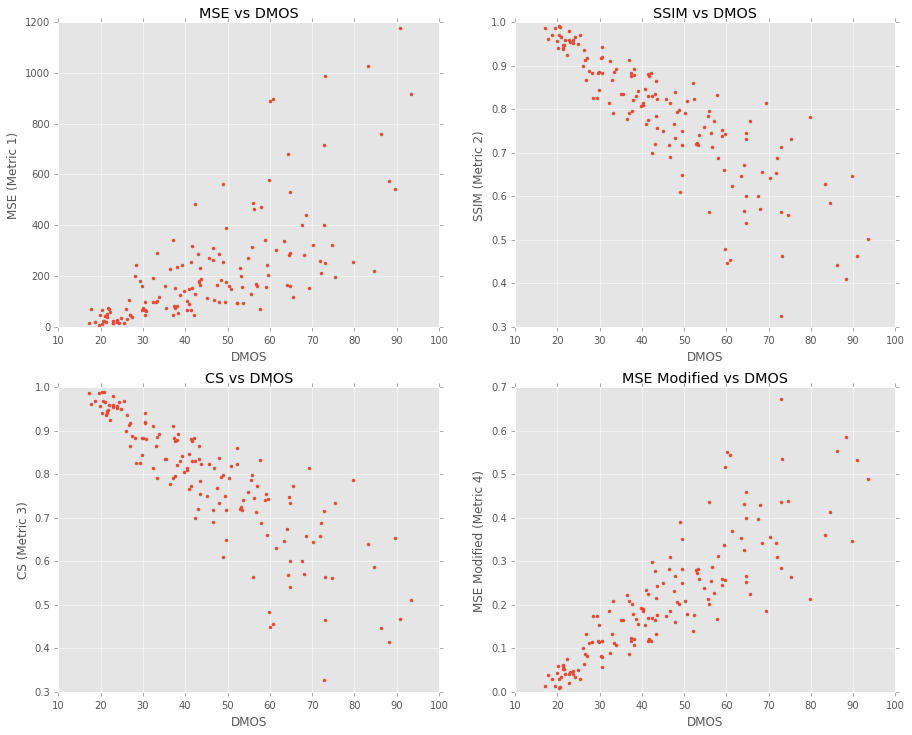

In [10]:
plt.rcParams["figure.figsize"] = (15,12);

plt.subplot(2,2,1)
plt.plot(dmos, m_res[:,0], '.')
plt.xlabel('DMOS')
plt.ylabel('MSE (Metric 1)')
plt.title('MSE vs DMOS')

plt.subplot(2,2,2)
plt.plot(dmos, m_res[:,1], '.')
plt.xlabel('DMOS')
plt.ylabel('SSIM (Metric 2)')
plt.title('SSIM vs DMOS')

plt.subplot(2,2,3)
plt.plot(dmos, m_res[:,2], '.')
plt.xlabel('DMOS')
plt.ylabel('CS (Metric 3)')
plt.title('CS vs DMOS')

plt.subplot(2,2,4)
plt.plot(dmos, m_res[:,3], '.')
plt.xlabel('DMOS')
plt.ylabel('MSE Modified (Metric 4)')
plt.title('MSE Modified vs DMOS')
plt.savefig('./Images/combine_res.png', dpi= 200, bbox_inches='tight', transparent=False),
plt.show()

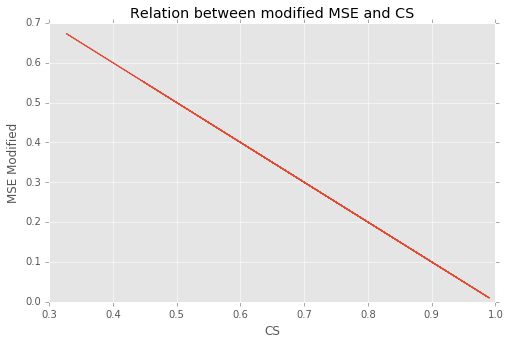

In [12]:
plt.rcParams["figure.figsize"] = (8,5);
plt.plot(m_res[:,2], m_res[:,3])
plt.title('Relation between modified MSE and CS')
plt.xlabel('CS')
plt.ylabel('MSE Modified')
plt.savefig('./Images/relation.png', dpi= 200, bbox_inches='tight', transparent=False),
plt.show()

### Extra evaluations: 

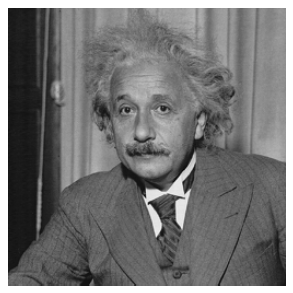

In [13]:
img_original  =  np.float32(plt.imread('./Images/original.gif', 0))
img_contrast  =  np.float32(plt.imread('./Images/contrast.gif', 0))
img_impulse   =  np.float32(plt.imread('./Images/impulse.gif', 0))
img_jpg       =  np.float32(plt.imread('./Images/jpg.gif', 0))
img_blur      =  np.float32(plt.imread('./Images/blur.gif', 0))
img_meanshift =  np.float32(plt.imread('./Images/meanshift.gif', 0))

hp.show(img_original)

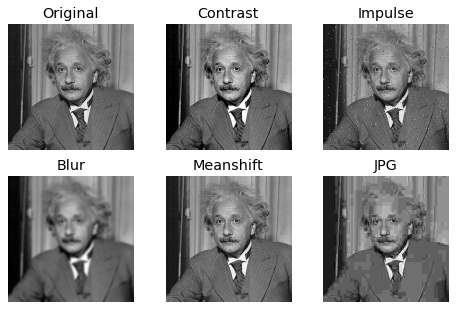

In [14]:
hp.subShow(2,3,1, img_original, 'Original')
hp.subShow(2,3,2, img_contrast, 'Contrast')
hp.subShow(2,3,3, img_impulse, 'Impulse')
hp.subShow(2,3,4, img_blur, 'Blur')
hp.subShow(2,3,5, img_meanshift, 'Meanshift')
hp.subShow(2,3,6, img_jpg, 'JPG')
plt.savefig('./Images/compare_img.png', dpi= 200, bbox_inches='tight', transparent=False),
plt.show()

In [15]:
contrast_res, impulse_res, jpg_res, blur_res, meanshift_res = [],[],[],[],[]

contrast_res.append(metric1(img_contrast, img_original))
contrast_res.append(metric2(img_contrast, img_original))
contrast_res.append(metric3(img_contrast, img_original))
contrast_res.append(metric4(img_contrast, img_original))

blur_res.append(metric1(img_blur, img_original))
blur_res.append(metric2(img_blur, img_original))
blur_res.append(metric3(img_blur, img_original))
blur_res.append(metric4(img_blur, img_original))

impulse_res.append(metric1(img_impulse, img_original))
impulse_res.append(metric2(img_impulse, img_original))
impulse_res.append(metric3(img_impulse, img_original))
impulse_res.append(metric4(img_impulse, img_original))

jpg_res.append(metric1(img_jpg, img_original))
jpg_res.append(metric2(img_jpg, img_original))
jpg_res.append(metric3(img_jpg, img_original))
jpg_res.append(metric4(img_jpg, img_original))

meanshift_res.append(metric1(img_meanshift, img_original))
meanshift_res.append(metric2(img_meanshift, img_original))
meanshift_res.append(metric3(img_meanshift, img_original))
meanshift_res.append(metric4(img_meanshift, img_original))

In [16]:
print(contrast_res)
print(blur_res)
print(impulse_res)
print(jpg_res)
print(meanshift_res)

[144.21881103515625, 0.90122139, 0.97620106, 0.023798889]
[143.90853881835938, 0.70227188, 0.70314234, 0.29685768]
[143.93902587890625, 0.83939064, 0.83947468, 0.16052528]
[141.95294189453125, 0.67009765, 0.67165232, 0.32834768]
[143.99446105957031, 0.98734683, 0.9999994, 5.4904547e-07]
